In [295]:
from simple_unet import multi_unet_model #Uses softmax 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm 



In [296]:
#Resizing images, if needed
SIZE_X = 512
SIZE_Y = 512
n_classes= 5 #Number of classes for segmentation

TRAIN_PATH_X = '/home/khamituly/Documents/Diploma work/dataset_manual/temp_health/X/'
TRAIN_PATH_Y = '/home/khamituly/Documents/Diploma work/dataset_manual/temp_health/Y_retina_choroid_sclera_outer/'

#512
# IMG_WIDTH = 512
# IMG_HEIGHT = 512
# IMG_CHANNELS = 3
train_ids_x = next(os.walk(TRAIN_PATH_X))[2]
train_ids_y = next(os.walk(TRAIN_PATH_Y))[2]

In [297]:
# #Capture training image info as a list
# train_images = []

# for directory_path in glob.glob("/home/khamituly/Documents/Diploma work/dataset_manual/new_segmented/x_full"):
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
#         img = cv2.imread(img_path, 0)       
#         img = cv2.resize(img, (SIZE_Y, SIZE_X))
#         train_images.append(img)    

# #Convert list to array for machine learning processing        
# train_images = np.array(train_images)

In [298]:
# #Capture mask/label info as a list
# train_masks = [] 
# for directory_path in glob.glob("/home/khamituly/Documents/Diploma work/dataset_manual/new_segmented/y_single_layer"):
#     for mask_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
#         mask = cv2.imread(mask_path, 0)       
#         mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
#         train_masks.append(mask)
        
# #Convert list to array for machine learning processing          
# train_masks = np.array(train_masks)

In [299]:
for n, id_ in enumerate(train_ids_x):
    print(n,id_)
    path = TRAIN_PATH_X + '/'+id_

    img = imread(path)
    # grayscale = rgb2gray(img)
    print(img.shape)

0 26 OD - Copy.jpeg
(500, 750, 3)
1 34 OS - Copy.jpeg
(500, 750, 3)
2 22 OD - Copy.jpeg
(500, 750, 3)
3 06 OS - Copy.jpeg
(500, 750, 3)
4 56 OS - Copy.jpeg
(500, 750, 3)
5 108 OD - Copy.jpeg
(500, 750, 3)
6 33 OD - Copy.jpeg
(500, 750, 3)
7 31 OD - Copy.jpeg
(500, 750, 3)
8 64 OD - Copy.jpeg
(500, 750, 3)
9 50 OD - Copy.jpeg
(500, 750, 3)


In [300]:
train_images = []
train_masks = []

In [301]:
for n, id_ in tqdm(enumerate(train_ids_x), total=len(train_ids_x)):
    #x
    path = TRAIN_PATH_X +id_
    # img = PIL.Image.open(path)
    # image_array = np.array(img)
    # img = imread(path)[:,:,:3]  

    # image_array_x = resize(img, (SIZE_Y, SIZE_X), mode='constant', preserve_range=True)
    img = cv2.imread(path, 0)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)

    # y 
    size = len(id_)
    # y_id = id_[:size - 5]
    path_y = TRAIN_PATH_Y+id_

    # img_y = PIL.Image.open(path_y).convert('RGB')
        
    # img_y = imread(path_y)[:,:,:1]
    # img_y = imread(path_y)
    # grayscale_y = rgb2gray(img_y)
    # image_y = np.array(img_y)
    
    mask =  cv2.imread(path_y, 0)  
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
    train_masks.append(mask)


train_masks = np.array(train_masks)
train_images = np.array(train_images)

100%|██████████| 10/10 [00:00<00:00, 176.28it/s]


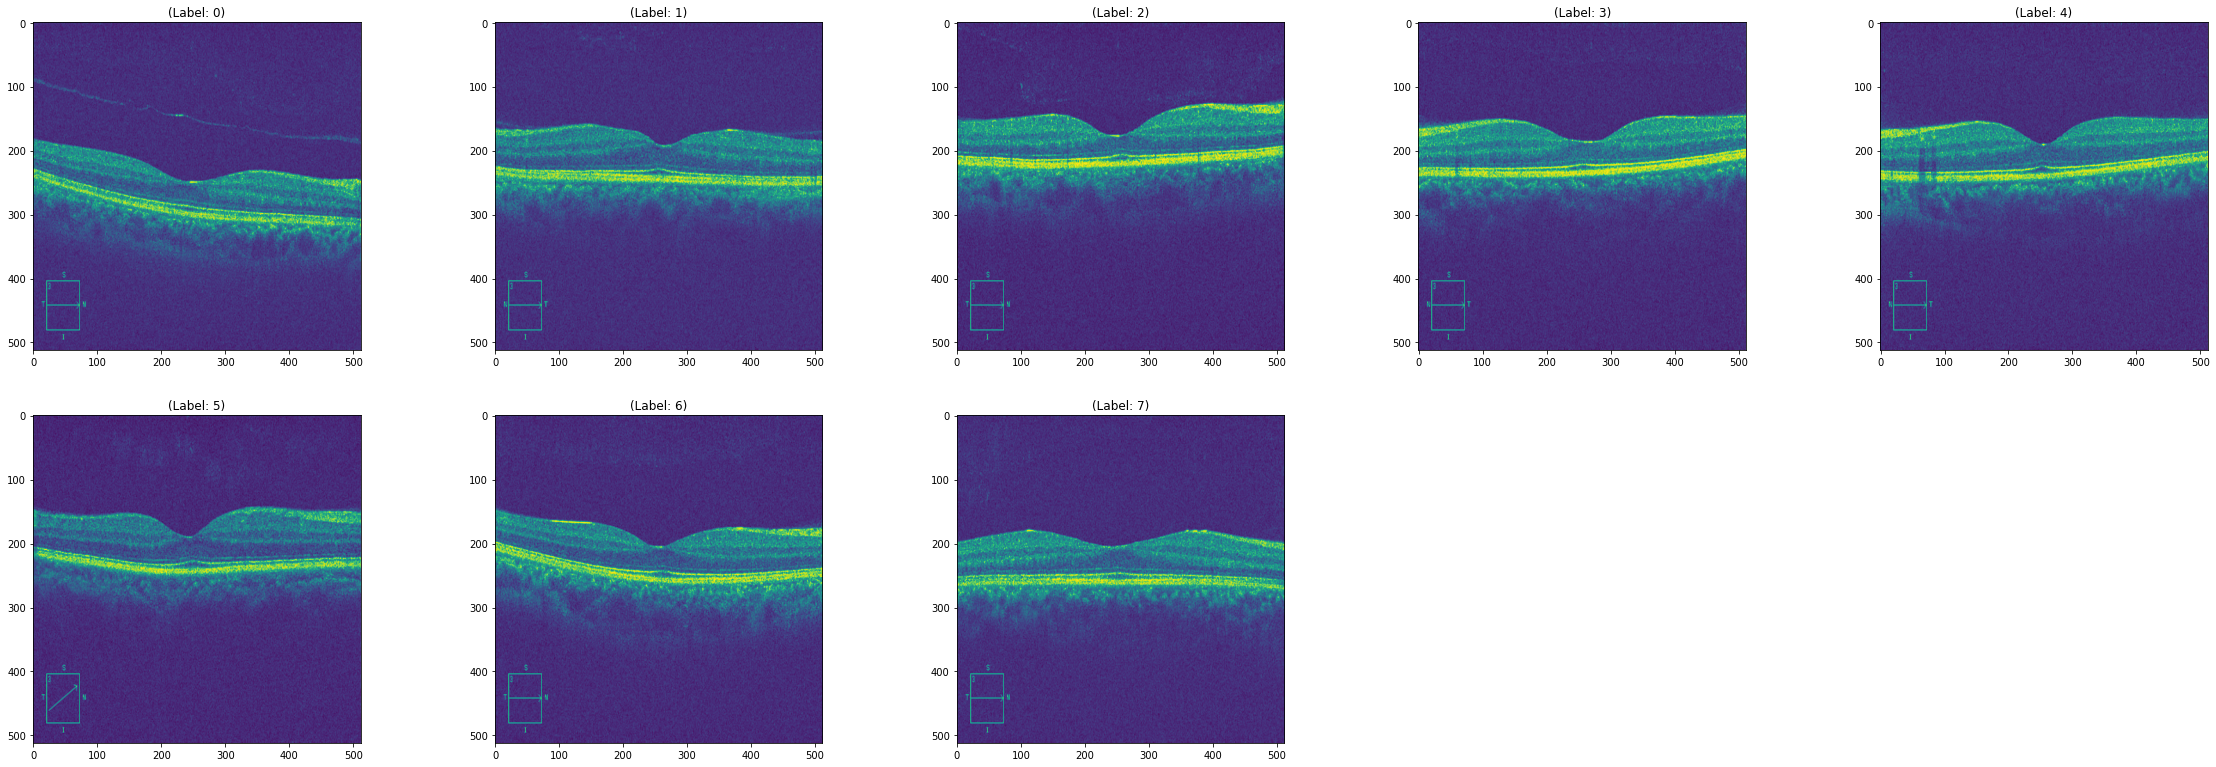

In [302]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_images[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

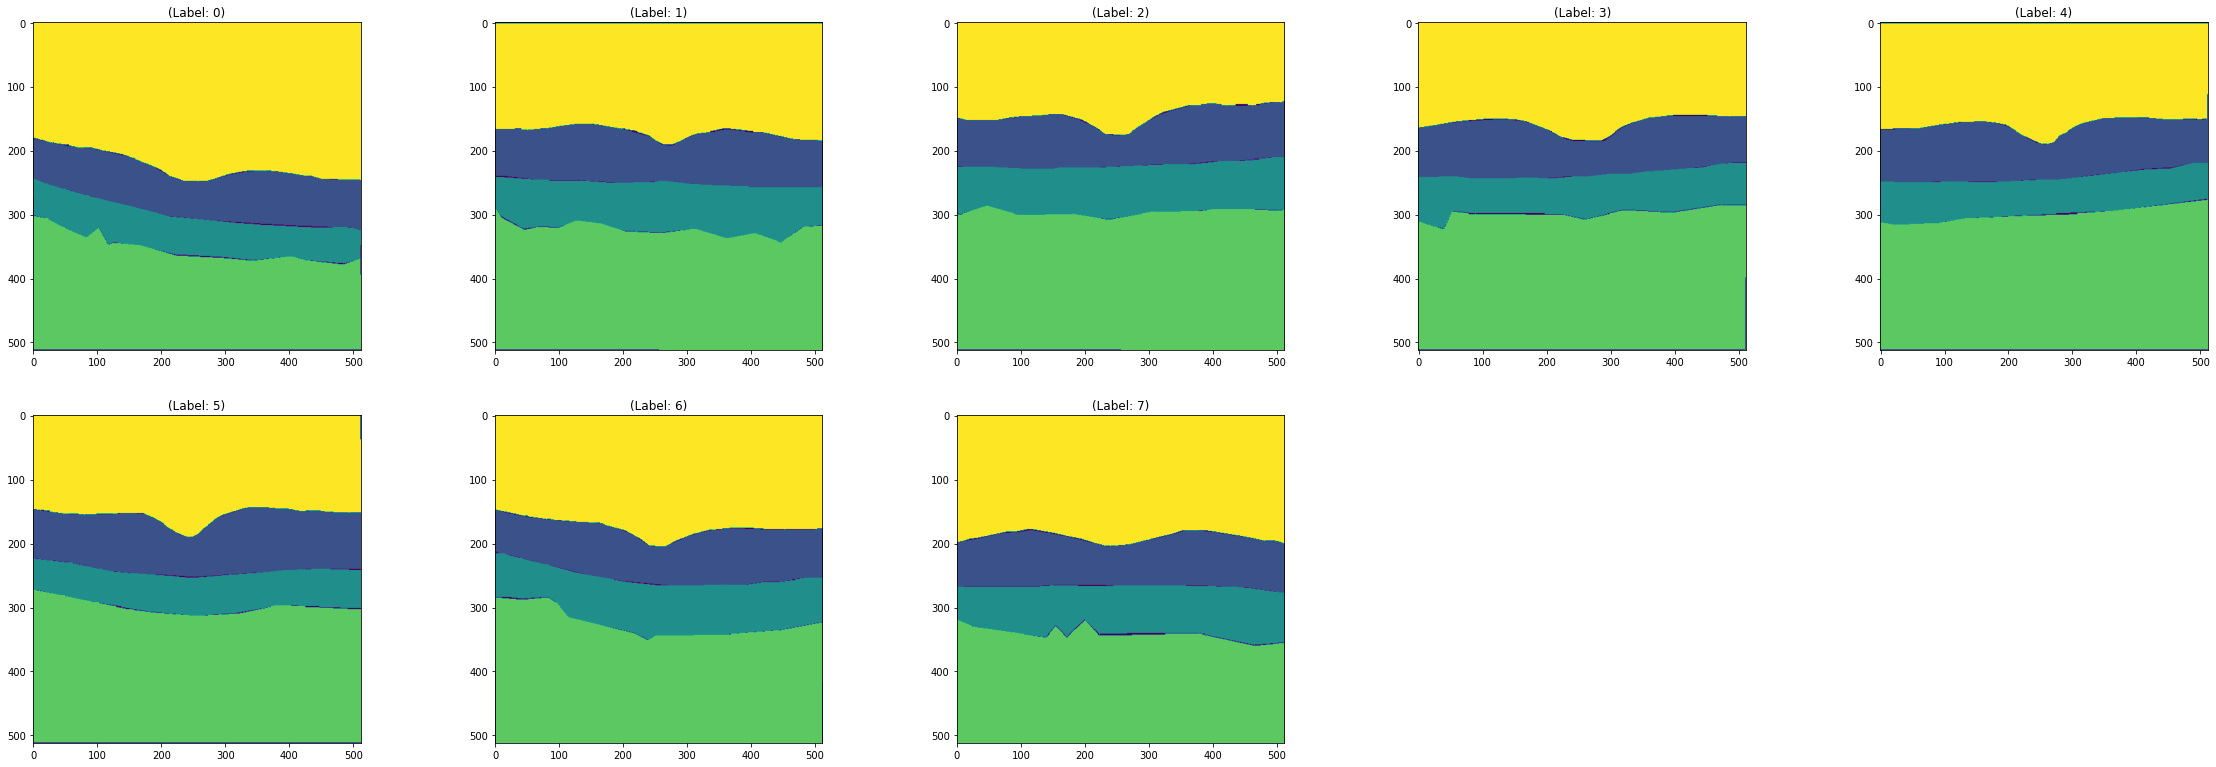

In [303]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_masks[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

In [304]:

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


In [305]:

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2 3 4]


In [306]:

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [307]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [32.86453959  1.32433081  1.52606715  0.53677445  0.58954802]


In [308]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 512, 512, 16) 160         input_9[0][0]                    
__________________________________________________________________________________________________
dropout_72 (Dropout)            (None, 512, 512, 16) 0           conv2d_152[0][0]                 
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 512, 512, 16) 2320        dropout_72[0][0]                 
____________________________________________________________________________________________

In [309]:

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    

# model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")



Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 1.6119 - accuracy: 0.2405 - val_loss: 1.6060 - val_accuracy: 0.3084
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 1.6056 - accuracy: 0.3393 - val_loss: 1.6033 - val_accuracy: 0.2957
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 1.6016 - accuracy: 0.3595 - val_loss: 1.5994 - val_accuracy: 0.3246
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 1.5975 - accuracy: 0.3674 - val_loss: 1.5940 - val_accuracy: 0.3781
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 1.5923 - accuracy: 0.3786 - val_loss: 1.5875 - val_accuracy: 0.4112
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 1.5858 - accuracy: 0.3869 - val_loss: 1.5798 - val_accuracy: 0.4300
Epoch 7/100
1/1 [==============================] - 5s 5s/step - loss: 1.5776 - accuracy: 0.3892 - val_loss: 1.5692 - val_accuracy: 0.4607
Epoch 8/100
1/1 [=================

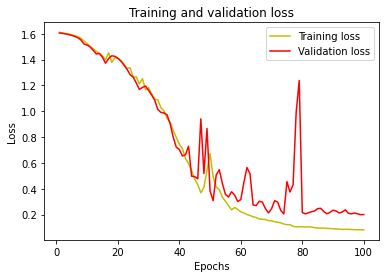

In [310]:


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [311]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

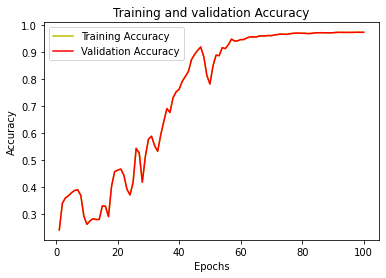

In [312]:

acc = history.history['accuracy']
val_acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [313]:
##################################
#model = get_model()
# model.load_weights('sandstone_50_epochs_catXentropy_acc.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
# X_test = 
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

################

In [314]:

##################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 245
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())



Mean IoU = 0.69114196


[[0.0000e+00 2.9400e+02 3.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 3.9001e+04 7.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.8100e+03 2.3690e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]
IoU for class1 is:  0.0
IoU for class2 is:  0.9473620287602021
IoU for class3 is:  0.6268356573968724
IoU for class4 is:  0.8963647203913786


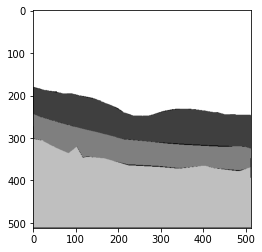

In [315]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

In [316]:
# model.save('retina_segmentation_retina_choroid_sclera.hdf5')

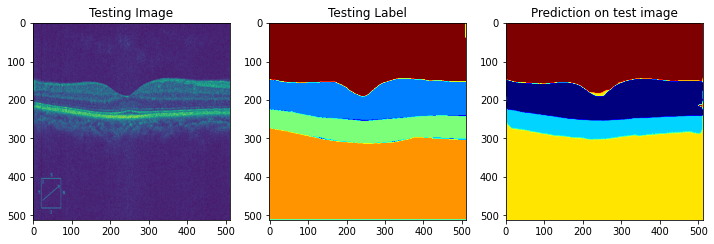

In [325]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  

import random
test_img_number = 2
test_img = X_train[test_img_number]
ground_truth= y_train[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

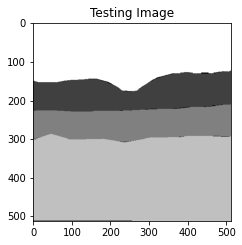

In [318]:
plt.figure(figsize=(20, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(y_test[0,:,:], cmap='gray')

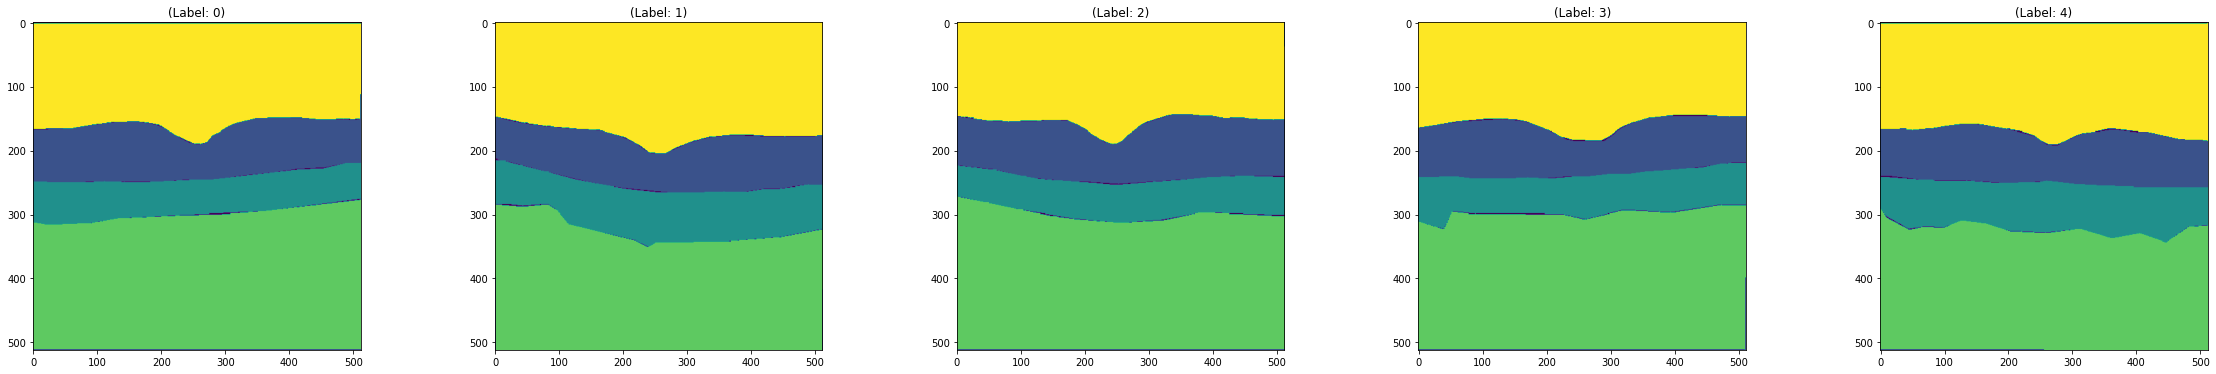

In [319]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

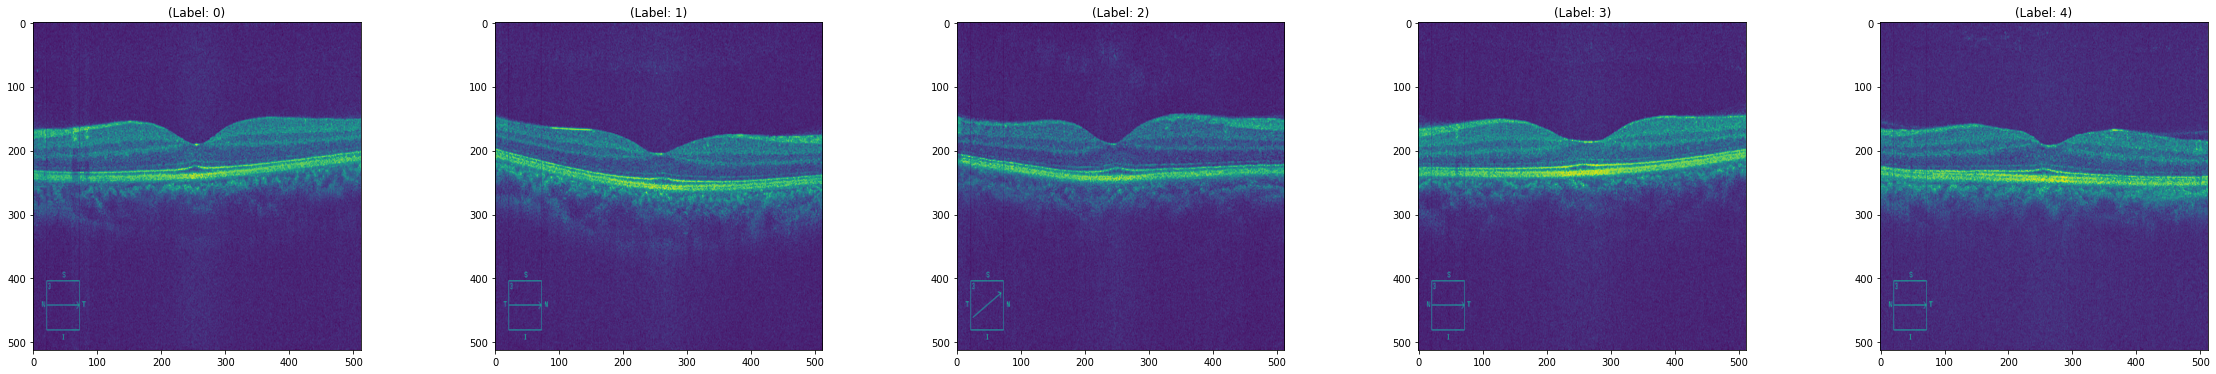

In [320]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

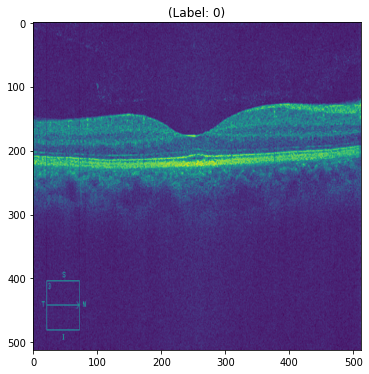

In [321]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

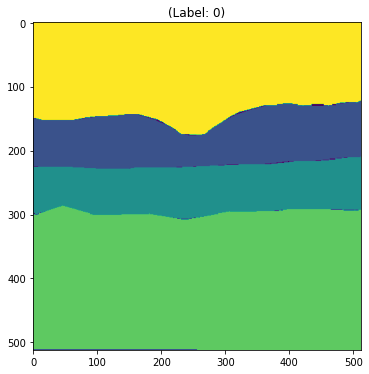

In [322]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   